In [1]:
# !pip install catboost

In [2]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.stats import gmean, rankdata

pd.set_option("display.max_columns", 30)

In [3]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [4]:
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# # !kaggle datasets download -d  geekbrains-competitive-data-analysis
# !kaggle competitions download -c geekbrains-competitive-data-analysis

In [5]:
# !kaggle -v

In [6]:
# !unzip -q /content/geekbrains-competitive-data-analysis.zip -d /content/data

## Useful Functions

In [7]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "data"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=50,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


# def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
#     """
#     Hold-Out валидация для модели catbooost.

#     Parameters
#     ----------
#     params: dict
#         Словарь гиперпараметров модели.

#     X: pandas.core.frame.DataFrame
#         Матрица признаков для обучения модели.

#     y: pandas.core.frame.Series
#         Вектор целевой переменной для обучения модели.

#     split_params: List[float], optional, default = [0.7, 0.2, 0.1]
#         Параметры (доли) разбиения выборки.
#         Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].
    
#     categorical: str, optional, default = None
#         Список категориальных признаков.
#         Опциональный параметр, по умолчанию, не используется.

#     Returns
#     -------
#     estimator: catboost.core.CatBoostClassifier
#         Обученный классификатор catboost.

#     test_prediction: np.array, optional
#         Вектор прогнозов для тестовой выборки.
#         Опциональный объект, возвращается только, если split_params
#         содержит 3 значения.

#     """
#     numeric = list(set(x_train.columns) - set(categorical))
#     x_train, x_valid = train_test_split(
#         X, train_size=split_params[0], random_state=27
#     )
#     y_train, y_valid = train_test_split(
#         y, train_size=split_params[0], random_state=27
#     )

#     if len(split_params) == 3:
#         test_size = int(split_params[2] * X.shape[0])

#         x_valid, x_test = train_test_split(
#             x_valid, test_size=test_size, random_state=72
#         )
#         y_valid, y_test = train_test_split(
#             y_valid, test_size=test_size, random_state=72
#         )

#     model = cb.CatBoostClassifier(**params)
#     model.fit(
#         x_train, y_train, categorical,
#         eval_set=[(x_train, y_train), (x_valid, y_valid)]
#     )

#     print("="*80)
#     valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
#     print(f"Valid Score = {round(valid_score, 4)}")

#     if len(split_params) == 3:

#         test_prediction = model.predict_proba(x_test)[:, 1]
#         test_score = roc_auc_score(y_test, test_prediction)
#         print(f"Test Score = {round(test_score, 4)}")

#         return estimator, test_prediction

#     else:
#         return estimator

In [8]:
def split_features(df):
    categorical_features = df.select_dtypes(include=[np.object]).columns
    numerical_features = list(set(df.columns) - set(categorical_features))
    return numerical_features, categorical_features

def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3
    X["log_external_scoring_rating_1"] = np.log(X["external_scoring_rating_1"])
    X["log_external_scoring_rating_2"] = np.log(X["external_scoring_rating_2"])
    X["log_external_scoring_rating_3"] = np.log(X["external_scoring_rating_3"])

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]

    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    X["log_total_salary"] = np.log(X["total_salary"])
    X["log_amount_credit"] = np.log(X["amount_credit"])
    X["log_amount_credity"] = np.log(X["amount_annuity"])

    

    return X

## Base Tables

In [9]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


## Client_profile

In [10]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,...,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,log_total_salary,log_amount_credit,log_amount_credity
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,...,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,11.967181,12.506177,9.510445
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,...,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,12.506177,13.193600,10.256501


In [11]:
data = data.merge(
    client_profile, how="left", on="application_number"
)
data.shape

(275234, 61)

In [12]:
def append_to_data(data: pd.DataFrame, X: pd.DataFrame, groupby: str="application_number"):
    X = X.replace(365243, np.nan)
    X = X.groupby(groupby).mean()

    data = data.merge(X, how="left", on=groupby)

    return data

payments = get_input("payments.csv")
payments['day_instalment_payment_ratio'] = payments["days_instalment"]/payments['days_entry_payment']
payments['installment_payment_ratio'] = payments["amt_instalment"]/payments['amt_payment']

payments["pay_log_days_entry_payment"] = np.log(payments["days_entry_payment"])
payments["pay_log_amt_instalment"] = np.log(payments["amt_instalment"])
payments["pay_log_amt_payment"] = np.log(payments["amt_payment"])

bki = get_input("bki.csv")
bki['day_fact_enddate'] = bki['days_enddate_fact'] / bki['days_credit_enddate']
bki['dlr'] = (bki['amt_credit_sum_debt']+0)/(bki['amt_credit_sum']+1) 
bki['ratio_overdue'] = (bki['amt_credit_max_overdue']+0)/(bki['amt_credit_sum']+1)

appl_history = get_input("applications_history.csv")
appl_history['count_history'] = appl_history.groupby(['application_number'])['prev_application_number'].count()

# data = append_to_data(data, payments)
# data = append_to_data(data, bki)
# data = append_to_data(data, appl_history)

data = data.reset_index(drop=True)

payments.csv: shape = 1023932 rows, 8 cols


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


bki.csv: shape = 945234 rows, 17 cols
applications_history.csv: shape = 1670214 rows, 26 cols


In [13]:
data.shape

(275234, 61)

In [14]:
payments.head()

,prev_application_number,application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment,day_instalment_payment_ratio,installment_payment_ratio,pay_log_days_entry_payment,pay_log_amt_instalment,pay_log_amt_payment
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615,0.987192,1.000000,6.922644,9.405629,9.405629
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645,1.023148,1.830532,6.068426,9.819700,9.215094
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945,0.347826,1.000000,3.135494,8.612493,8.612493
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145,1.000000,1.000000,5.986452,8.865332,8.865332
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735,1.000000,1.000000,7.214504,5.054556,5.054556


In [15]:
bki.head()

,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity,day_fact_enddate,dlr,ratio_overdue
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN,NaN,0.474467,0.028721
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN,1.000000,0.000000,0.000000
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0,1.073826,0.000000,NaN
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN,NaN,0.979141,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00,0.000,0.0,0.0,Credit card,116.0,NaN,NaN,0.000000,NaN


In [16]:
appl_history.head()

,prev_application_number,application_number,name_contract_type,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,sellerplace_area,cnt_payment,name_yield_group,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,count_history
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0,NaN
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0,NaN
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0,NaN
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0,NaN
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# !pip install shap

In [18]:
# import matplotlib.pyplot as plt
# import shap

In [19]:
# shap_values = shap.TreeExplainer(estimators[2]).shap_values(data)
# shap.summary_plot(shap_values, data, plot_type="bar")

## Baseline

In [20]:
categorial = data.dtypes[data.dtypes == "object"].index
numerical = list(set(data.columns) - set(categorial))
data[numerical] = data[numerical].astype(float)
data[categorial] = data[categorial].astype('category')

data = pd.get_dummies(data)

mask = data["target"].isnull()
train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(["application_number", "target"], axis=1)
test = test.drop(["application_number", "target"], axis=1)
t_categorial = train.dtypes[train.dtypes == "object"].index
t_numerical = list(set(train.columns) - set(t_categorial))

data.head(3)

,application_number,target,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,...,name_contract_type_Credit Card,gender_F,gender_M,gender_XNA,education_level_Academic degree,education_level_Higher education,education_level_Incomplete higher,education_level_Lower secondary,education_level_Secondary / secondary special,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Unknown,family_status_Widow
0,123687442.0,0.0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,...,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
1,123597908.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,123526683.0,0.0,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


## KFold

In [21]:
cb_params = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 50,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 20,
    "early_stopping_rounds": 150,
    "thread_count": 6,
    "random_seed": 42,
    # "silent": True
}

lgbm_cv = KFold(n_splits=4, random_state=128, shuffle=True)

lgbm_estimators, lgbm_oof = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=lgbm_cv, categorical=t_categorial
)

Tue Dec 22 19:58:15 2020, Cross-Validation, 110093 rows, 71 cols
0:	test: 0.6699621	test1: 0.6809742	best: 0.6809742 (0)	total: 126ms	remaining: 10m 31s
100:	test: 0.7094858	test1: 0.7147752	best: 0.7147752 (100)	total: 7.75s	remaining: 6m 15s
200:	test: 0.7154423	test1: 0.7188814	best: 0.7188814 (200)	total: 15.5s	remaining: 6m 9s
300:	test: 0.7208949	test1: 0.7220343	best: 0.7220931 (296)	total: 23.2s	remaining: 6m 2s
400:	test: 0.7263096	test1: 0.7240221	best: 0.7240337 (398)	total: 31s	remaining: 5m 55s
500:	test: 0.7305062	test1: 0.7259735	best: 0.7261237 (495)	total: 38.6s	remaining: 5m 46s
600:	test: 0.7340618	test1: 0.7275578	best: 0.7275691 (599)	total: 46.1s	remaining: 5m 37s
700:	test: 0.7369826	test1: 0.7288603	best: 0.7288603 (700)	total: 54s	remaining: 5m 31s
800:	test: 0.7396858	test1: 0.7299861	best: 0.7301118 (797)	total: 1m 1s	remaining: 5m 22s
900:	test: 0.7422446	test1: 0.7302385	best: 0.7303355 (869)	total: 1m 9s	remaining: 5m 14s
1000:	test: 0.7447425	test1: 0.730

In [22]:
lgbm_oof_score = roc_auc_score(
    target, lgbm_oof
)
print(f"OOF-score = {round(lgbm_oof_score, 5)}")


OOF-score = 0.72702


In [23]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.01",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "early_stopping": 50,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=4, random_state=42, shuffle=True)


xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    params=xgb_params, X=train, y=target, cv=xgb_cv
)

Tue Dec 22 20:07:41 2020, Cross-Validation, 110093 rows, 71 cols
[0]	train-auc:0.693134	valid-auc:0.694554
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.711878	valid-auc:0.714527
[200]	train-auc:0.718638	valid-auc:0.720261
[300]	train-auc:0.727547	valid-auc:0.725772
[400]	train-auc:0.73464	valid-auc:0.729926
[500]	train-auc:0.740618	valid-auc:0.733403
[600]	train-auc:0.744571	valid-auc:0.735313
[700]	train-auc:0.747552	valid-auc:0.73644
[800]	train-auc:0.749976	valid-auc:0.737557
[900]	train-auc:0.752104	valid-auc:0.738429
[1000]	train-auc:0.754059	valid-auc:0.73906
[1100]	train-auc:0.755916	valid-auc:0.739687
Stopping. Best iteration:
[1100]	train-auc:0.755916	valid-auc:0.739687

Fold 1, Valid score = 0.73965
[0]	train-auc:0.688142	valid-auc:0.683013
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't imp

In [24]:
xgb_oof_score = roc_auc_score(
    target, xgb_oof
)
print(f"OOF-score = {round(xgb_oof_score, 5)}")


OOF-score = 0.72779


## Подготовка прогноза

In [25]:
y_pred_xgb = np.zeros(test.shape[0])
test[t_numerical] = test[t_numerical].astype(float)
test[t_categorial] = test[t_categorial].astype(str)

dtest = xgb.DMatrix(data=test)

for estimator in xgb_estimators:
    y_pred_xgb += estimator.predict(dtest)


y_pred_xgb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb / xgb_cv.n_splits
})
y_pred_xgb["APPLICATION_NUMBER"] = y_pred_xgb["APPLICATION_NUMBER"].astype(int)
y_pred_xgb.to_csv("baseline_submit_xgb_II.csv", index=False)

In [26]:
y_pred_lgbm = np.zeros(test.shape[0])
test[t_numerical] = test[t_numerical].astype(float)
test[t_categorial] = test[t_categorial].astype(str)

for estimator in lgbm_estimators:
    y_pred_lgbm += estimator.predict_proba(test)[:, 1]


y_pred_lgbm = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_lgbm / lgbm_cv.n_splits
})
y_pred_lgbm["APPLICATION_NUMBER"] = y_pred_lgbm["APPLICATION_NUMBER"].astype(int)
y_pred_lgbm.to_csv("baseline_submit_y_pred_lgbm_II.csv", index=False)

In [27]:
scores_train = pd.DataFrame({
    "lgbm": lgbm_oof,
    "xgb": xgb_oof,
    
})

corr_train = scores_train.corr()
mask = np.zeros_like(corr_train, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

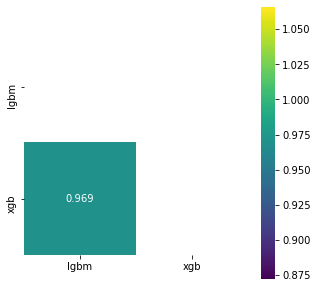

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr_train, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [40]:
scores_mean = scores_train.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7284


In [41]:
scores_mean = gmean(scores_train, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7285


In [42]:
scores_mean = scores_train.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7282


In [43]:
scores_mean = gmean(scores_train.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7282


In [64]:
cb_params = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 20,
    "early_stopping_rounds": 150,
    "thread_count": 6,
    "random_seed": 42
}

cb_cv = KFold(n_splits=4, random_state=42, shuffle=True)

cb_estimators, cb_oof = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cb_cv, categorical=t_categorial
)

Tue Dec 22 21:04:02 2020, Cross-Validation, 110093 rows, 71 cols
0:	test: 0.6503239	test1: 0.6488028	best: 0.6488028 (0)	total: 74.5ms	remaining: 6m 12s
100:	test: 0.7088356	test1: 0.7169709	best: 0.7170141 (90)	total: 7.48s	remaining: 6m 2s
200:	test: 0.7141780	test1: 0.7206272	best: 0.7206272 (200)	total: 14.9s	remaining: 5m 55s
300:	test: 0.7191451	test1: 0.7230852	best: 0.7232729 (296)	total: 22.5s	remaining: 5m 51s
400:	test: 0.7246863	test1: 0.7266123	best: 0.7266940 (394)	total: 30.1s	remaining: 5m 45s
500:	test: 0.7289672	test1: 0.7287669	best: 0.7288071 (498)	total: 37.7s	remaining: 5m 38s
600:	test: 0.7324552	test1: 0.7303142	best: 0.7303942 (597)	total: 45.3s	remaining: 5m 31s
700:	test: 0.7358364	test1: 0.7314296	best: 0.7314303 (698)	total: 52.7s	remaining: 5m 23s
800:	test: 0.7386949	test1: 0.7325928	best: 0.7327042 (784)	total: 1m	remaining: 5m 15s
900:	test: 0.7412192	test1: 0.7330030	best: 0.7330743 (894)	total: 1m 7s	remaining: 5m 7s
1000:	test: 0.7437841	test1: 0.733

In [65]:
cb_oof_score = roc_auc_score(
    target, cb_oof)
print(f"OOF-score = {round(cb_oof_score, 5)}")


OOF-score = 0.72538


In [66]:
scores_train_3 = pd.DataFrame({
    "lgbm": lgbm_oof,
    "xgb": xgb_oof,
    "cb": cb_oof,
    
})

corr_train_3 = scores_train_3.corr()
mask = np.zeros_like(corr_train_3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

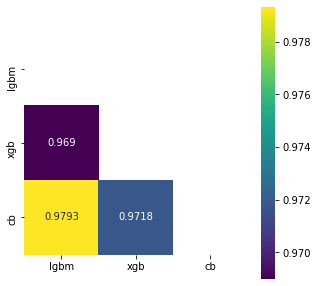

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr_train_3, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [72]:
scores_mean = scores_train_3.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7278


In [73]:
scores_mean = gmean(scores_train_3, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7279


In [74]:
scores_mean = scores_train_3.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7276


In [75]:
scores_mean = gmean(scores_train_3.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7277
